# A/B Testing 
compares Control and Standard Treatments to assess statistical differences, aiming for a significance level of 5% (alpha) & Test statistic is The Mean, using Permutation Test & Chi2 Test.

# Import Python Libraries

In [1]:
# import Libraries
import pandas as pd
import random
import scipy.stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Read Dataset Web Technology Landing page effect 

In [10]:
web_data = pd.read_csv('ab_data.csv')
web_data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


# Check Duplicated & Null Values

In [4]:
# Check Null Values
if web_data.isnull().any().any()==0:
    print('No Null Values')
else:
    print('Null Values exist. Removing Them is on')
    web_data.dropna()
    print('Done!')

No Null Values


In [5]:
# Check Dupliacted Values
if web_data.duplicated().sum()==0:
    print('No Dupliacted Values')
else:
    print('Duplicated Values exist. Removing Them is on')
    web_data.drop_duplicates()
    print('Done!')

No Dupliacted Values


# Features Data Types Treatment

In [11]:
# Rename and Change the DataTypes
web_data.rename(columns={'timestamp':'SessionTime'}, inplace=True)
# Change the data type of 'SessionTime' to 'datetime'
web_data["SessionTime"] = pd.to_timedelta('00:' + web_data["SessionTime"])
# Convert to seconds
web_data["SessionTime_seconds"] = web_data["SessionTime"].dt.total_seconds()
for column in web_data.columns:
    if web_data[column].dtype=='O':
        web_data[column]=web_data[column].astype('category')

In [12]:
# Verification
web_data.head()

,user_id,SessionTime,group,landing_page,converted,SessionTime_seconds
0,851104,0 days 00:11:48.600000,control,old_page,0,708.6
1,804228,0 days 00:01:45.200000,control,old_page,0,105.2
2,661590,0 days 00:55:06.200000,treatment,new_page,0,3306.2
3,853541,0 days 00:28:03.100000,treatment,new_page,0,1683.1
4,864975,0 days 00:52:26.200000,control,old_page,1,3146.2


# Visualize The Control/Treatment Grp based on the Session Time/Conversion 

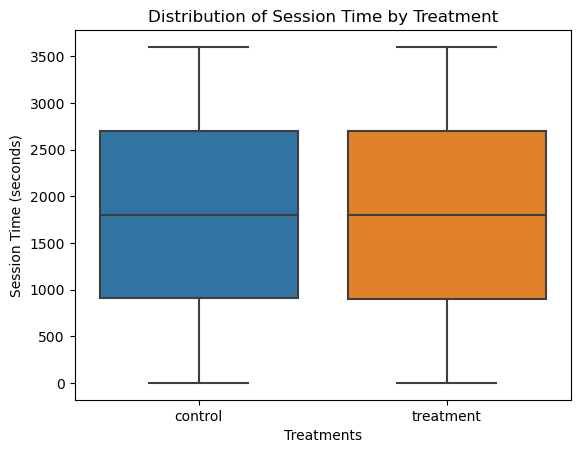

In [19]:
# Visualization of the Session Time for Each Treatment
sns.boxplot(x='group', y='SessionTime_seconds', data=web_data)
plt.title('Distribution of Session Time by Treatment')
plt.xlabel('Treatments')
plt.ylabel('Session Time (seconds)')
plt.show()

As we can see both Control and Treatment startegies have the same effect on Session Time.

In [32]:
# let's group our data based on group type and see impact on sessionTime and Conversion
web_data_by_group_seconds= web_data.groupby('group')['SessionTime_seconds'].mean().sort_values(ascending=False).reset_index()
web_data_by_group_conversion = web_data.groupby('group')['converted'].count().sort_values(ascending=False).reset_index()
web_data_by_group_seconds

,group,SessionTime_seconds
0,control,1804.763441
1,treatment,1801.506825


In [33]:
# Analysis the improvment of each startegy on Time and Conversion
improve_conversion = (web_data_by_group_conversion.iloc[0,1]-web_data_by_group_conversion.iloc[1,1])/web_data_by_group_conversion.iloc[:,1].sum()
improve_time = (web_data_by_group_seconds.iloc[1,1]-web_data_by_group_seconds.iloc[0,1])/web_data_by_group_seconds.iloc[:,1].sum()
if improve_conversion>0:
    print(f'We have Conversion improvment by percenatge of:{round(improve_conversion*100,2)}')
else:
    print(f'We have no improvment at all {round(improve_conversion*100,2)}')
if improve_time>0:
    print(f'We have Time improvment by percenatge of:{round(improve_time*100,2)}')
else:
    print(f'We have no improvment at all {round(improve_time*100,2)}')

We have Conversion improvment by percenatge of:0.03
We have no improvment at all -0.09


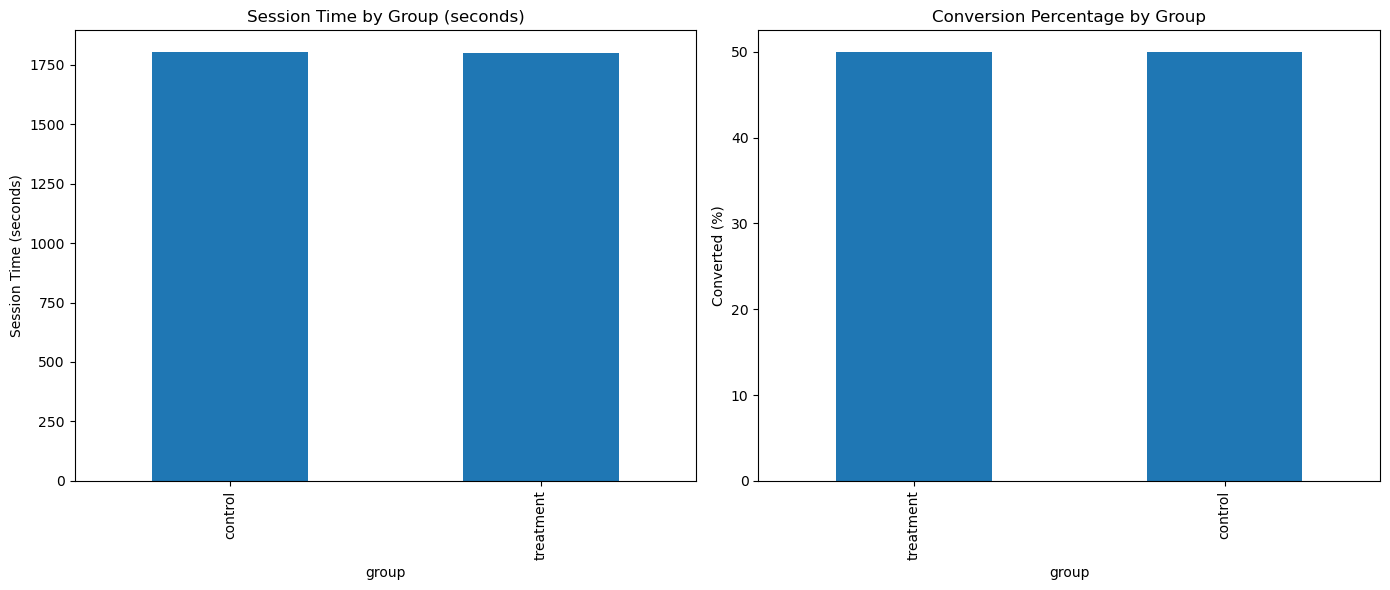

In [34]:
# Visualization
# Calculate the total conversions
total_conversions = web_data_by_group_conversion['converted'].sum()
# Calculate percentage of conversions
web_data_by_group_conversion['converted_percentage'] = (web_data_by_group_conversion['converted'] / total_conversions) * 100

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot SessionTime_seconds
web_data_by_group_seconds.plot(x='group', y='SessionTime_seconds', kind='bar', ax=ax1, legend=False)
ax1.set_title('Session Time by Group (seconds)')
ax1.set_ylabel('Session Time (seconds)')

# Plot converted percentage
web_data_by_group_conversion.plot(x='group', y='converted_percentage', kind='bar', ax=ax2, legend=False)
ax2.set_title('Conversion Percentage by Group')
ax2.set_ylabel('Converted (%)')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# Let's Start our A/B test on Conversion because we have improvment but to not be fooled by Randomness we must check p-values belwo a threshold of 5%.

# Permutation Test

In [3]:
# Permutation Test 
def permTest(data, nA, nB):
    n = nA + nB
    # Generate a random sample of size nB from the range [0, n) and convert it to a set
    idx_B = set(random.sample(range(n), nB))
    # Compute the complement of idx_B with respect to the range [0, n) and convert it to a set
    idx_A = set(range(n)) - idx_B
    # Convert idx_A and idx_B sets to lists
    idxA = list(idx_A)
    idxB = list(idx_B)
    # Calculate the difference in means between the two groups based on the selected indices
    return data.loc[idxA].mean() - data.loc[idxB].mean()

# Get Groups Size

In [52]:
# Grps Size
na =len(web_data[web_data['group']=="control"])
nb = len(web_data[web_data['group']=="treatment"])

# Observed Diff

In [55]:
# Creating Data Frame Results 
control = web_data[web_data['group']=="control"]
treatment = web_data[web_data['group']=="treatment"]
results = pd.DataFrame()
results= results._append({'Control Grp':len(control[control['converted']==1]),'Treatmnet Grp':len(treatment[treatment['converted']==1])},ignore_index=True)
results= results._append({'Control Grp':len(control[control['converted']==0]),'Treatmnet Grp':len(treatment[treatment['converted']==0])},ignore_index=True)
results.index = ['Converted', 'Not Converted']
results.head()

,Control Grp,Treatmnet Grp
Converted,17723,17514
Not Converted,129479,129762


In [57]:
# Calculate Real Difference
real_diff = results['Control Grp']['Converted'] / results['Control Grp'].sum() - results['Treatmnet Grp']['Converted'] / results['Treatmnet Grp'].sum()
print(f'The Control Grp has a significance of the treatment Grp by {round(real_diff * 100, 3)}%')

The Control Grp has a significance of the treatment Grp by 0.148%


# Calculate p-Value

In [58]:
# Create data Box to make the permutation Test
na = results['Control Grp'].sum()
nb = results['Treatmnet Grp'].sum()
box_data = [1]*results.loc['Converted'].sum()
box_data.extend([0]*results.loc['Not Converted'].sum())
data = pd.Series(box_data)
permDiff = [permTest(data,na,nb) for _ in range(1000)]

In [59]:
p_value = np.mean(permDiff>real_diff)
print(f'The p_value based on the Convertion {round(p_value*100,2)}%')

The p_value based on the Convertion 9.8%


# Using Chi2 Test
because we have in conveted binary data 1 or 0

In [60]:
from scipy import stats
survivors = np.array([[17723, 129479], [17514, 129762]])
chi2, p_value, df, freq_tab = stats.chi2_contingency(survivors)
print(f'p-value for single sided test: {p_value*100 / 2:.4f}%')

p-value for single sided test: 10.9116%


# Conclusion
The improvment in Conversion between Control & Treatment Groups may fall due to Randomness.

# Addition
Calculate Sample Size based on effect size 10%, power, and alpha.

In [62]:
import statsmodels.stats.proportion as smp

# Given proportions
prop1 = 0.0121
prop2 = 0.011

# Calculate effect size
effect_size = smp.proportion_effectsize(prop1, prop2)

print(f"The effect size (Cohen's h) for the given proportions is: {effect_size}")

The effect size (Cohen's h) for the given proportions is: 0.01029785095103608


In [65]:
#Get the effect Size based on given alpha power and effect size
import statsmodels.stats.power as smp
import statsmodels.stats


# Calculate the effect size
effect_size = statsmodels.stats.proportion.proportion_effectsize(0.0121, 0.011)

# Initialize an object for power analysis
analysis = smp.TTestIndPower()

# Solve for the sample size needed
result = analysis.solve_power(effect_size=effect_size, alpha=0.05, power=0.8, alternative='larger')

# Print the sample size
print(f'So, to have a Statistical Significance test the sample size is: {result:.3f}')

So, to have a Statistical Significance test the sample size is: 116602.393
